In [1]:
#colab
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
#cd /content/drive/MyDrive/Skoltech/8/myDL/Project

In [1]:
import numpy as np
from numba import njit
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import pandas as pd
import scipy
import scipy.signal
import cooler
import bioframe
import cooltools
from astropy.convolution import Gaussian2DKernel
from cooltools.lib.numutils import adaptive_coarsegrain, interp_nan
import collections
import pyranges as pr
import pickle

import os
import sys

### ----- FUNCTIONS -------
def seq_df(df, fasta_records, mapped_only=True, return_input=True):
    """
    Parameters
    ----------
    df : pandas.DataFrame
        A sets of genomic intervals stored as a DataFrame.
    fasta_records : OrderedDict
        Dictionary of chromosome names to sequence records.
        Created by: bioframe.load_fasta('/path/to/fasta.fa')
    mapped_only: bool
        if True, ignore 'N' in the fasta_records for calculation.
        if True and there are no mapped base-pairs in an interval, return np.nan.
    return_input: bool
        if False, only return Series named frac_mapped.
    Returns
    -------
    df_mapped : pd.DataFrame
        Original dataframe with new column 'frac_mapped' appended.
    """
    if not set(df["chrom"].values).issubset(set(fasta_records.keys())):
        return ValueError(
            "chrom from intervals not in fasta_records: double-check genome agreement"
        )
    if not type(fasta_records) is collections.OrderedDict:
        return ValueError(
            "fasta records must be provided as an OrderedDict, can be created by bioframe.load_fasta"
        )
    
    def _each(chrom_group):
        chrom = chrom_group.name
        seq = fasta_records[chrom]
        seq = str(seq[:])
        gc = []
        for _, bin in chrom_group.iterrows():
            s = seq[bin.start : bin.end]
            n = 0
            if mapped_only:
                n = s.count("N")
                n += s.count("n")
            gc.append(s if n == 0 else 'nan')
        return gc

    out = df.groupby("chrom", sort=False).apply(_each)

    if return_input:
        return pd.concat(
            [df, pd.Series(data=np.concatenate(out), index=df.index).rename("SEQ")],
            axis="columns",
        )
    else:
        return pd.Series(data=np.concatenate(out), index=df.index).rename("SEQ")
    
def dnorm(x, mu, sd):
    return 1 / (np.sqrt(2 * np.pi) * sd) * np.e ** (-np.power((x - mu) / sd, 2) / 2)

def gaussian_kernel(size, sigma=1, verbose=False):
 
    kernel_1D = np.linspace(-(size // 2), size // 2, size)
    for i in range(size):
        kernel_1D[i] = dnorm(kernel_1D[i], 0, sigma)
    kernel_2D = np.outer(kernel_1D.T, kernel_1D.T)
 
    kernel_2D *= 1.0 / kernel_2D.max()
 
    if verbose:
        plt.imshow(kernel_2D, interpolation='none',cmap='gray')
        plt.title("Image")
        plt.show()
 
    return kernel_2D / kernel_2D.sum() #normalizer kernel to sum to 1

def make_expected_vals(cooler, Ndiags):
    vals = {}
    for chrom in tqdm(list(cooler.chroms()[:]['name'])[:-1]): #remove the last chrY
        mat = cooler.matrix(balance=True, sparse=True).fetch(chrom)
        diags = scipy.sparse.triu(scipy.sparse.tril(mat, Ndiags), 0, 'dia')
        for i in range(Ndiags):
            if i not in vals:
                vals[i] = []
            arr = diags.data[i][diags.data[i]==diags.data[i]]
            vals[i].append([np.mean(arr), np.std(arr), arr.shape[0]]) #Std in case we want to do z-score
    avals = []
    for d in vals:
        l = np.sum([i[2] for i in vals[d]])
        m = np.array([i[0]*i[2] for i in vals[d]]).sum()/l
        s = np.array([i[1]*i[2] for i in vals[d]]).sum()/l
        avals.append((m ,s))
    return np.array(avals)

def hic_preprocess(A, E, mask, G_kernel=None):
    """
    G_kernel:: 2d array: 
        200 pixels: (size=3, std=1.); 
        100 pixels: (size=3, std=0.6)
    """
    #---mask empty bins---
    A[mask, :] = np.nan
    A[:, mask] = np.nan
    #---OBS/EXP---
    E = scipy.linalg.toeplitz(E) #toeplitz expected matrix
    A_min = np.nanmin(A.ravel()[np.nonzero(A.ravel())])
    A_ = np.where(A==0., E, A) #np.where(A==0., A_min / 2, A) #fill zeros with (minimal nonzero / 2)
    #np.fill_diagonal(A_, np.nanmean(np.diag(A_, 0))) #fill diagonal of A with average main diagonal value
    R = np.array(np.log(A_ / E))
    R = cooltools.lib.numutils.interp_nan(R, method='linear') #linear interpolation
    
    if G_kernel is not None:
        #---SMOOTHING---
        R_ = scipy.signal.convolve2d(R, G_kernel, mode='same', boundary='fill')
        R_ = np.clip(R_, -2, 2)
        return R_
    else:
        R_ = np.clip(R, -2, 2)
        return R_
    
def zero_one_preprocess(A, mask):
    #---mask empty bins---
    A[mask, :] = np.nan
    A[:, mask] = np.nan
    
    T = np.array(A + np.nanmin(A[np.nonzero(A)]))
    T /= np.nanmax(T)
    T = np.log2(T)
    T -= np.nanmin(T)
    T = cooltools.lib.numutils.interp_nan(T, method='linear')
    T /= np.nanmax(T)
    return T

In [2]:
#arguments
GENOME_PATH = './data/GRCm38.p6.genome.fa'
GENOME_REPORT_PATH = './data/GCF_000001635.20_GRCm38_assembly_report.txt'
GENOME_GAPS_FILE = './data/gap_mm10.bed'
#HIC_PATH = './data/4DNFI17N23FN.mcool'
#HIC_PATH = '../Sirtuin6/Hi-C/WT/coolers_library/WT_female_2.mm10.mapq_30.1000.mcool'
HIC_PATH = './data/4DNFINNZDDXV.mcool'

HIGH_RESOLUTION_BINSIZE = 5000
LOW_RESOLUTION_BINSIZE = 10000
N_PIXELS_HIGH = 200
N_PIXELS_LOW = 100

# GENOME

In [3]:
#mouse example
binsize = 5000
mm10 = bioframe.fetch_chromsizes('mm10')
chromsizes = bioframe.fetch_chromsizes('mm10')
chromosomes = list(chromsizes.index)

In [4]:
#fasta_records = bioframe.load_fasta('data/GCF_000001635.27_GRCm39_genomic.fna')
fasta_records = bioframe.load_fasta(GENOME_PATH)
bins = cooler.binnify(mm10, binsize)

In [5]:
seqdf = seq_df(bins, fasta_records, mapped_only=True, return_input=True)
seqdf = seqdf[~seqdf['chrom'].isin(['chrM', 'chrY'])] #drop poor coverage chromosomes
seqdf = seqdf[seqdf['SEQ'] != 'nan'] #drop sequences with N bases

In [6]:
seqdf

,chrom,start,end,SEQ
601,chr1,3005000,3010000,CAAATGTTACTATTATAAACATATATTCTGGGCTGCTGAATTTTGT...
602,chr1,3010000,3015000,CTTAGGTTTGGTCTTTTCATAGTGTCCCAGATTTCCTGGCTGTTTC...
603,chr1,3015000,3020000,TTCCACCTATAGGGTTGCAGTTCCCATTAGCTCCTTGGGTAATTTC...
604,chr1,3020000,3025000,TTCCAGATTTCTTTCCTAGGGTTTCTATCTCCAGCGTTGCCTCACT...
605,chr1,3025000,3030000,GTATAGCGACAGACAGGTAGACCAATGAAATAGATTTGAAGACCCA...
...,...,...,...,...
526729,chrX,170855000,170860000,GTGACAGGGCCTCACATCCTCTACTGTGTGTGTGTCAGGGCCTGAC...
526730,chrX,170860000,170865000,CCTCACATCCGCTCCTGTGTGTGTGGCAGCACCTCACATTTTCTGC...
526731,chrX,170865000,170870000,CTCACATCCTCTGCTGTGTGTGTGTCAGGGCCTCACATCCTCTGCT...
526732,chrX,170870000,170875000,CCAACATCACTGTAAATGTATGCTTCATTGACAATATATTTGATTC...


In [7]:
#gaps drop
gaps = pd.read_csv(GENOME_GAPS_FILE, sep='\t', header=None)
gaps.columns = ['id', 'Chromosome', 'Start', 'End', 'id2', 'N', 'Length', 'Type', 'Bool']
gaps = gaps.drop(['id', 'N', 'id2'], 1)

In [8]:
a = seqdf[['chrom', 'start', 'end']]
a.columns = ['Chromosome', 'Start', 'End']
b = gaps[['Chromosome', 'Start', 'End']]

ar = pr.PyRanges(a)
br = pr.PyRanges(b)

gap_intervals = ar.join(br)
gap_intervals = gap_intervals.df  #[['Chromosome', 'Start', 'End']]

In [9]:
if len(gap_intervals) == 0:
    seqdf = seqdf
else:
    NotImplementedError

# HI-C

In [10]:
cool_high = cooler.Cooler(HIC_PATH + "::/resolutions/%d" % HIGH_RESOLUTION_BINSIZE)
cool_low = cooler.Cooler(HIC_PATH + "::/resolutions/%d" % LOW_RESOLUTION_BINSIZE)

In [13]:
EXP_HIGH = make_expected_vals(cool_high, N_PIXELS_HIGH)[:, 0]
EXP_LOW = make_expected_vals(cool_low, N_PIXELS_LOW)[:, 0]

/home/d.kriukov/.local/lib/python3.7/site-packages/scipy/sparse/coo.py:432: SparseEfficiencyWarning: Constructing a DIA matrix with 201 diagonals is inefficient
  "is inefficient" % len(diags), SparseEfficiencyWarning)


/home/d.kriukov/.local/lib/python3.7/site-packages/scipy/sparse/coo.py:432: SparseEfficiencyWarning: Constructing a DIA matrix with 101 diagonals is inefficient
  "is inefficient" % len(diags), SparseEfficiencyWarning)


In [68]:
chrom = 'chr7'
start = 130_000_000
end = 131_000_000

BH = cool_high.bins().fetch('%s:%d-%d' % (chrom, start, end))
BL = cool_low.bins().fetch('%s:%d-%d' % (chrom, start, end))
binmask_high = np.argwhere(np.isnan(np.array(BH['weight'])))
binmask_low = np.argwhere(np.isnan(np.array(BL['weight'])))
AH = cool_high.matrix(balance=True, sparse=True).fetch('%s:%d-%d' % (chrom, start, end)).todense()
AL = cool_low.matrix(balance=True, sparse=True).fetch('%s:%d-%d' % (chrom, start, end)).todense()
#non-balanced
UH = cool_high.matrix(balance=False, sparse=True).fetch('%s:%d-%d' % (chrom, start, end)).todense()
UL = cool_low.matrix(balance=False, sparse=True).fetch('%s:%d-%d' % (chrom, start, end)).todense()

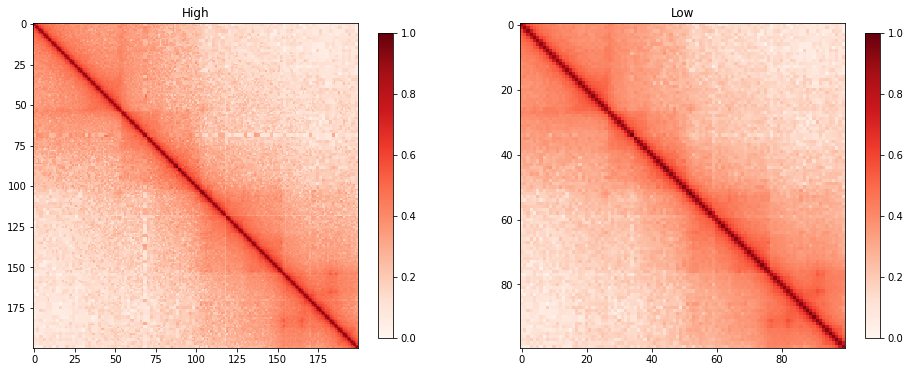

In [69]:
TH = zero_one_preprocess(adaptive_coarsegrain(AH, UH, cutoff=2, max_levels=8), binmask_high)
TL = zero_one_preprocess(adaptive_coarsegrain(AL, UL, cutoff=2, max_levels=8), binmask_low)

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
M1 = ax[0].imshow(TH, cmap='Reds', interpolation='none',)
M2 = ax[1].imshow(TL, cmap='Reds', interpolation='none',)
ax[0].set_title('High')
ax[1].set_title('Low')
plt.colorbar(M1, ax=ax[0], shrink=0.7)
plt.colorbar(M2, ax=ax[1], shrink=0.7)
plt.show()

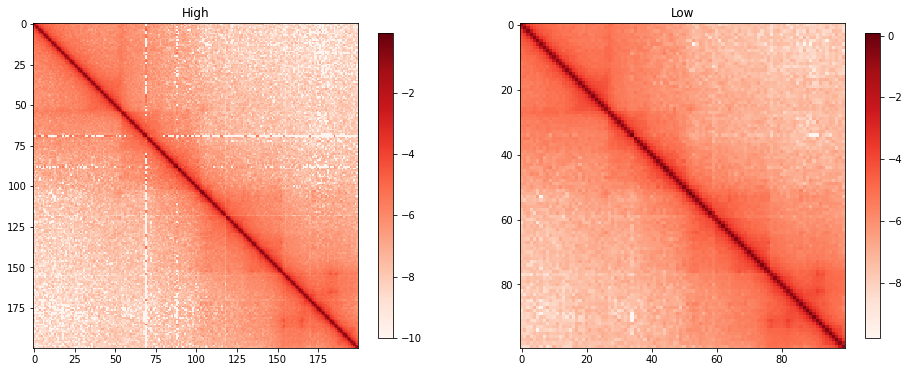

In [70]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
M1 = ax[0].imshow(np.log(AH + np.nanmin(AH[np.nonzero(AH)])), cmap='Reds', interpolation='none',)
M2 = ax[1].imshow(np.log(AL + np.nanmin(AL[np.nonzero(AL)])), cmap='Reds', interpolation='none',)
ax[0].set_title('High')
ax[1].set_title('Low')
plt.colorbar(M1, ax=ax[0], shrink=0.7)
plt.colorbar(M2, ax=ax[1], shrink=0.7)
plt.show()

In [17]:
#coarse grained variant
cgH = adaptive_coarsegrain(AH, UH, cutoff=2, max_levels=8)
cgL = adaptive_coarsegrain(AL, UL, cutoff=2, max_levels=8)

R_high = hic_preprocess(cgH, EXP_HIGH, binmask_high, G_kernel=Gaussian2DKernel(0.8))
R_low = hic_preprocess(cgL, EXP_LOW, binmask_low, G_kernel=Gaussian2DKernel(0.8))

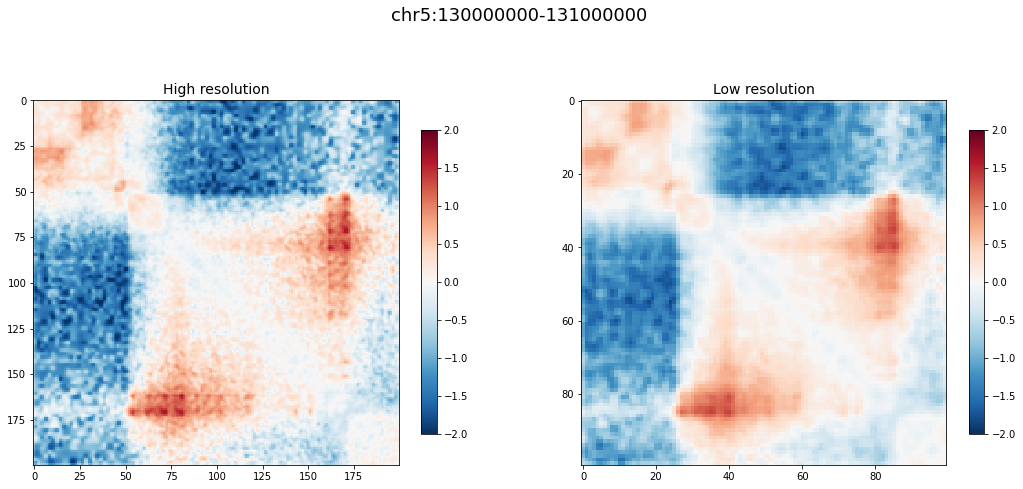

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('%s:%d-%d' % (chrom, start, end), fontsize=18)
M1 = ax[0].imshow(R_high, cmap='RdBu_r', interpolation='none', vmin=-2.0, vmax=2.0)
M2 = ax[1].imshow(R_low, cmap='RdBu_r', interpolation='none', vmin=-2.0, vmax=2.0)
ax[0].set_title('High resolution', fontsize=14)
ax[1].set_title('Low resolution', fontsize=14)
plt.colorbar(M1, ax=ax[0], shrink=0.7)
plt.colorbar(M2, ax=ax[1], shrink=0.7)
plt.show()

# Compilation

In [11]:
coord_list = []
high_list = []
low_list = []
seq_list = []
gkernel = Gaussian2DKernel(0.8)

for chrom in tqdm(chromosomes):
    seqdf_chrom = seqdf[seqdf['chrom']==chrom]
    n = len(seqdf_chrom) // N_PIXELS_HIGH
    if n == 0:
        continue
    else:
        for j in tqdm(range(n), leave=False):
            sub = seqdf_chrom.iloc[j * 200: (j + 1) * 200]
            start, end = sub.iloc[0]['start'], sub.iloc[-1]['end']
            if end - start != HIGH_RESOLUTION_BINSIZE * N_PIXELS_HIGH:
                continue

            sequence = ''.join(sub['SEQ'].tolist())
            assert len(sequence) == HIGH_RESOLUTION_BINSIZE * N_PIXELS_HIGH
            
            #---FETCHING---
            BH = cool_high.bins().fetch('%s:%d-%d' % (chrom, start, end))
            BL = cool_low.bins().fetch('%s:%d-%d' % (chrom, 
                                                     start // LOW_RESOLUTION_BINSIZE * LOW_RESOLUTION_BINSIZE, 
                                                     end // LOW_RESOLUTION_BINSIZE * LOW_RESOLUTION_BINSIZE
                                                    ))# this for correct fetching of low resolution
            binmask_high = np.argwhere(np.isnan(np.array(BH['weight'])))
            binmask_low = np.argwhere(np.isnan(np.array(BL['weight'])))
            #balanced
            AH = cool_high.matrix(balance=True, sparse=True).\
                    fetch('%s:%d-%d' % (chrom, start, end)).todense()
            AL = cool_low.matrix(balance=True, sparse=True).\
                    fetch('%s:%d-%d' % (chrom, 
                                        start // LOW_RESOLUTION_BINSIZE * LOW_RESOLUTION_BINSIZE, 
                                        end // LOW_RESOLUTION_BINSIZE * LOW_RESOLUTION_BINSIZE
                                       )).todense() # this for correct fetching of low resolution
            #non-balanced
            UH = cool_high.matrix(balance=False, sparse=True).fetch('%s:%d-%d' % (chrom, start, end)).todense()
            UL = cool_low.matrix(balance=False, sparse=True).fetch('%s:%d-%d' % (chrom, 
                                        start // LOW_RESOLUTION_BINSIZE * LOW_RESOLUTION_BINSIZE, 
                                        end // LOW_RESOLUTION_BINSIZE * LOW_RESOLUTION_BINSIZE
                                       )).todense()
            
            assert AH.shape[0] == N_PIXELS_HIGH, 'Wrong shape fetched'
            assert AL.shape[0] == N_PIXELS_LOW, 'Wrong shape fetched'
            assert UH.shape[0] == N_PIXELS_HIGH, 'Wrong shape fetched'
            assert UL.shape[0] == N_PIXELS_LOW, 'Wrong shape fetched'
            
            #---PREPROCESSING---
            #coarse grained variant
            cgH = adaptive_coarsegrain(AH, UH, cutoff=2, max_levels=8)
            cgL = adaptive_coarsegrain(AL, UL, cutoff=2, max_levels=8)
            
            #zero-one normalization
            R_high = zero_one_preprocess(cgH, binmask_high)
            R_low = zero_one_preprocess(cgL, binmask_low)
            
            #O/E matrices
            #R_high = hic_preprocess(cgH, EXP_HIGH, binmask_high, G_kernel=gkernel)
            #R_low = hic_preprocess(cgL, EXP_LOW, binmask_low, G_kernel=gkernel)
            
#             #---GATHERING---
            coord_list.append((chrom, start, end))
            high_list.append(R_high)
            low_list.append(R_low)
            seq_list.append(sequence)
            

/home/d.kriukov/.local/lib/python3.7/site-packages/cooltools/lib/numutils.py:1355: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur


In [39]:
#augmentation for VEHICLE
coord_list = []
high_list = []
low_list = []
gkernel = Gaussian2DKernel(0.8)

for chrom in tqdm(chromosomes):
    seqdf_chrom = seqdf[seqdf['chrom']==chrom]
    n = len(seqdf_chrom) // N_PIXELS_HIGH
    if n == 0:
        continue
    else:
        for j in tqdm(range(n), leave=False):
            for k in [0, 50, 100, 150]: #slicing
                sub = seqdf_chrom.iloc[j * 200 + k: (j + 1) * 200 + k]
                start, end = sub.iloc[0]['start'], sub.iloc[-1]['end']
                if end - start != HIGH_RESOLUTION_BINSIZE * N_PIXELS_HIGH:
                    continue

            
                #---FETCHING---
                BH = cool_high.bins().fetch('%s:%d-%d' % (chrom, start, end))
                BL = cool_low.bins().fetch('%s:%d-%d' % (chrom, 
                                                         start // LOW_RESOLUTION_BINSIZE * LOW_RESOLUTION_BINSIZE, 
                                                         end // LOW_RESOLUTION_BINSIZE * LOW_RESOLUTION_BINSIZE
                                                        ))# this for correct fetching of low resolution
                binmask_high = np.argwhere(np.isnan(np.array(BH['weight'])))
                binmask_low = np.argwhere(np.isnan(np.array(BL['weight'])))
                #balanced
                AH = cool_high.matrix(balance=True, sparse=True).\
                        fetch('%s:%d-%d' % (chrom, start, end)).todense()
                AL = cool_low.matrix(balance=True, sparse=True).\
                        fetch('%s:%d-%d' % (chrom, 
                                            start // LOW_RESOLUTION_BINSIZE * LOW_RESOLUTION_BINSIZE, 
                                            end // LOW_RESOLUTION_BINSIZE * LOW_RESOLUTION_BINSIZE
                                           )).todense() # this for correct fetching of low resolution
                #non-balanced
                UH = cool_high.matrix(balance=False, sparse=True).fetch('%s:%d-%d' % (chrom, start, end)).todense()
                UL = cool_low.matrix(balance=False, sparse=True).fetch('%s:%d-%d' % (chrom, 
                                            start // LOW_RESOLUTION_BINSIZE * LOW_RESOLUTION_BINSIZE, 
                                            end // LOW_RESOLUTION_BINSIZE * LOW_RESOLUTION_BINSIZE
                                           )).todense()

                assert AH.shape[0] == N_PIXELS_HIGH, 'Wrong shape fetched'
                assert AL.shape[0] == N_PIXELS_LOW, 'Wrong shape fetched'
                assert UH.shape[0] == N_PIXELS_HIGH, 'Wrong shape fetched'
                assert UL.shape[0] == N_PIXELS_LOW, 'Wrong shape fetched'

                #---PREPROCESSING---
                #coarse grained variant
                cgH = adaptive_coarsegrain(AH, UH, cutoff=2, max_levels=8)
                cgL = adaptive_coarsegrain(AL, UL, cutoff=2, max_levels=8)

                #zero-one normalization
                R_high = zero_one_preprocess(cgH, binmask_high)
                R_low = zero_one_preprocess(cgL, binmask_low)

                #O/E matrices
                #R_high = hic_preprocess(cgH, EXP_HIGH, binmask_high, G_kernel=gkernel)
                #R_low = hic_preprocess(cgL, EXP_LOW, binmask_low, G_kernel=gkernel)

    #             #---GATHERING---
                coord_list.append((chrom, start, end))
                high_list.append(R_high)
                low_list.append(R_low)

/opt/Anaconda/2020/lib/python3.7/site-packages/ipykernel_launcher.py:142: RuntimeWarning: All-NaN slice encountered
/opt/Anaconda/2020/lib/python3.7/site-packages/ipykernel_launcher.py:143: RuntimeWarning: All-NaN slice encountered
/opt/Anaconda/2020/lib/python3.7/site-packages/ipykernel_launcher.py:145: RuntimeWarning: All-NaN slice encountered
/opt/Anaconda/2020/lib/python3.7/site-packages/ipykernel_launcher.py:147: RuntimeWarning: invalid value encountered in true_divide


In [74]:
#filtering
CC = []
HH = []
LL = []
for i, c in enumerate(coord_list):
    if (np.isnan(high_list[i]).any()) or (np.isnan(low_list[i]).any()):
        continue
    CC.append(c)
    HH.append(high_list[i])
    LL.append(low_list[i])

## save

In [77]:
high_stack = np.stack(HH).astype(np.float32)
low_stack = np.stack(LL).astype(np.float32)

In [79]:
#save coords
with open('./dataset/coords_v2.txt', 'wb') as f:
    pickle.dump(CC, f)

In [78]:
np.save('./dataset/high_tensor_observed_v2.npy', high_stack)
np.save('./dataset/low_tensor_observed_v2.npy', low_stack)

In [40]:
high_stack = np.stack(high_list).astype(np.float32)
low_stack = np.stack(low_list).astype(np.float32)

In [15]:
np.save('./dataset/high_tensor_observed.npy', high_stack)
np.save('./dataset/low_tensor_observed.npy', low_stack)

In [ ]:
#save normalization constants
with open('./dataset/normalization.txt', 'wb') as f:
    pickle.dump([list(EXP_HIGH), list(EXP_LOW)], f)

In [ ]:
#save sequences
with open('./dataset/sequences.txt', 'wb') as f:
    pickle.dump(seq_list, f)
    
#save coords
with open('./dataset/coords.txt', 'wb') as f:
    pickle.dump(coord_list, f)
    
#save maps
np.save('./dataset/high_tensor_v2.npy', high_stack)
np.save('./dataset/low_tensor_v2.npy', low_stack)

# Load

In [ ]:
#load sequences
with open('./dataset/sequences.txt', 'rb') as f:
    seq_list = pickle.load(f)

#load coords
with open('./dataset/coords.txt', 'rb') as f:
    coord_list = pickle.load(f)

#load tensors
high_stack = np.load('./dataset/high_tensor.npy')
low_stack = np.load('./dataset/low_tensor.npy')

In [3]:
high_stack = np.load('./dataset/high_tensor_observed.npy')
low_stack = np.load('./dataset/low_tensor_observed.npy')

## vizualisation

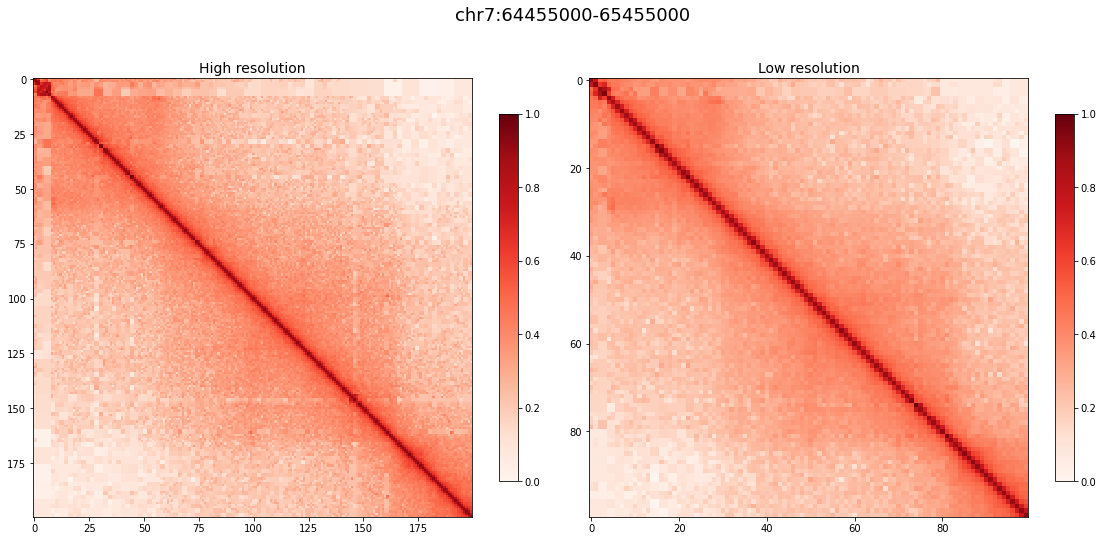

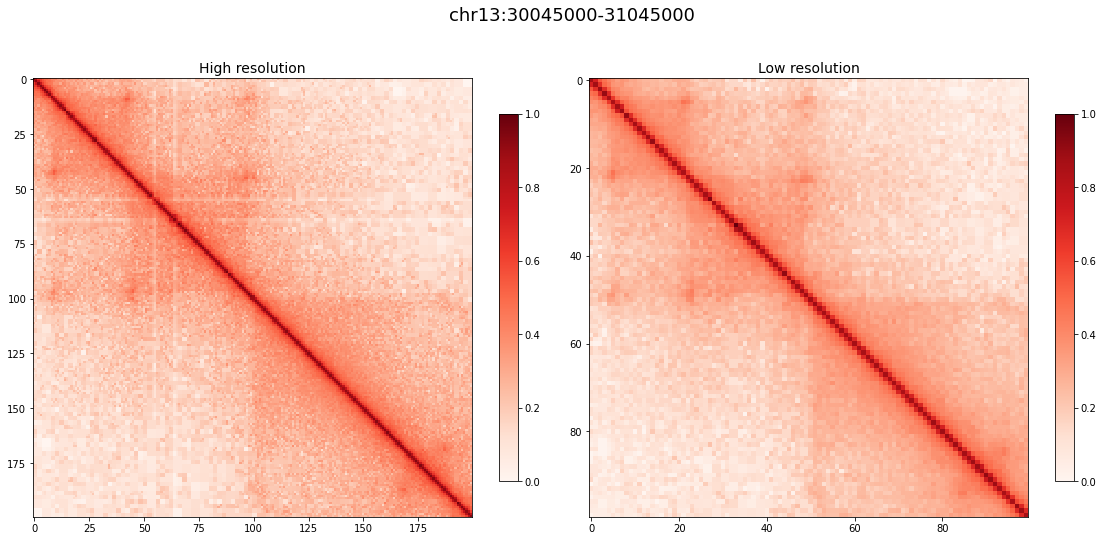

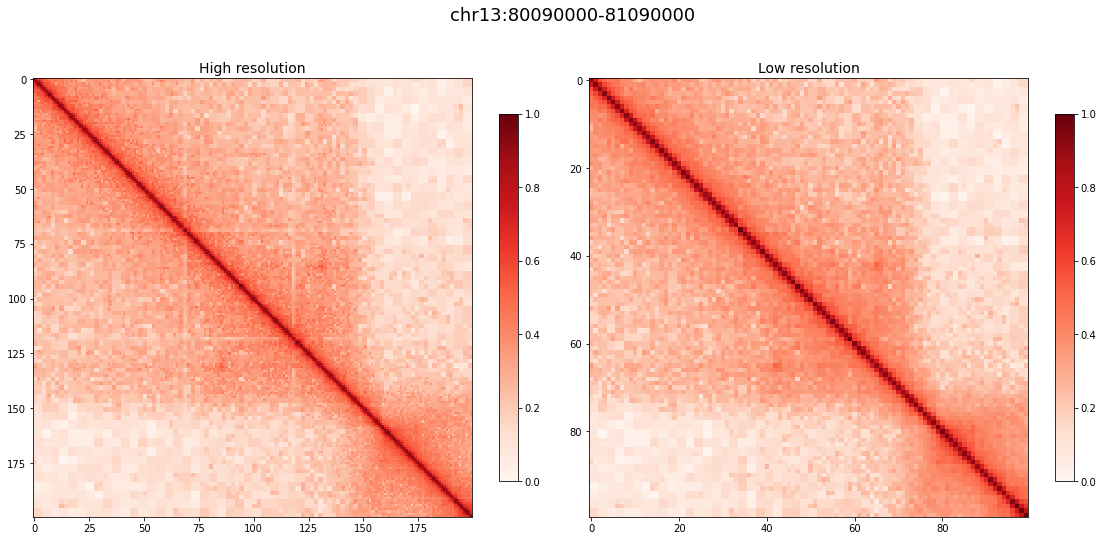

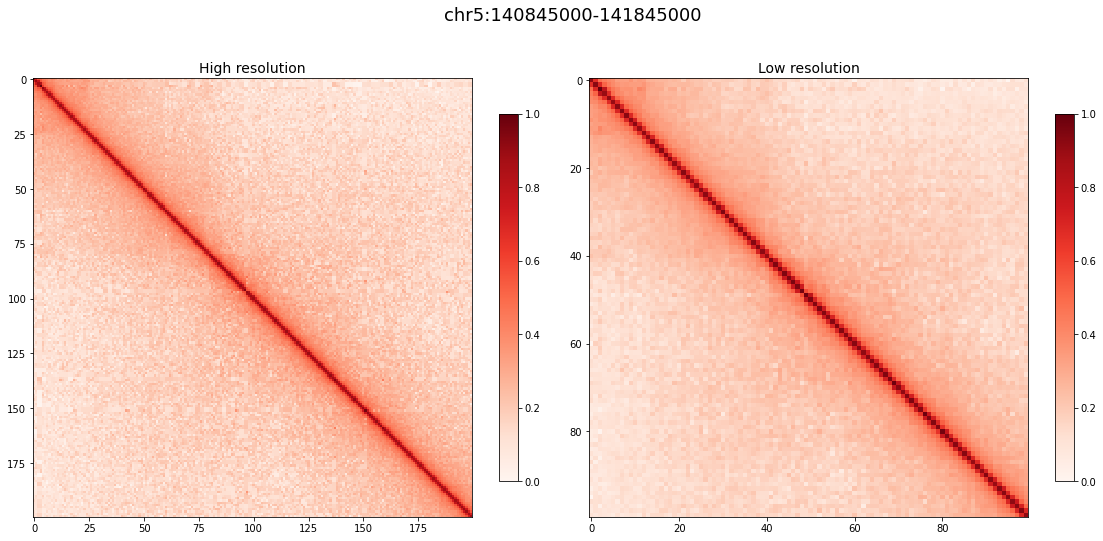

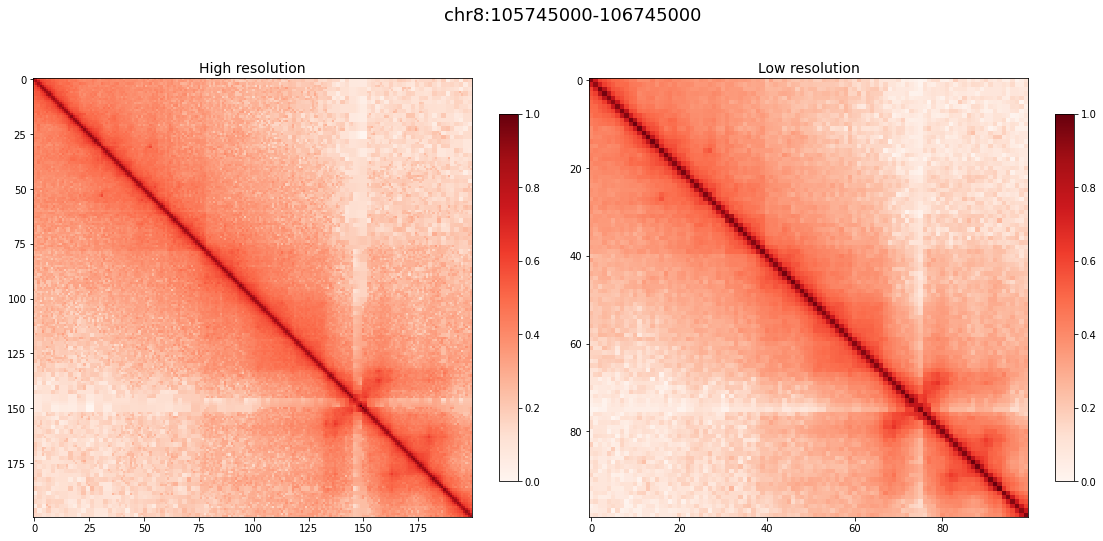

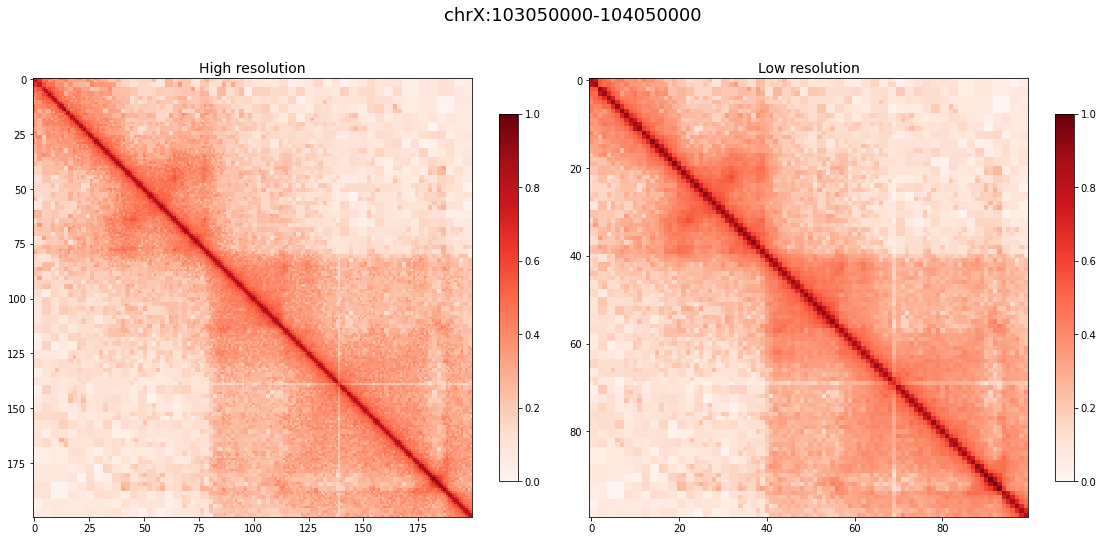

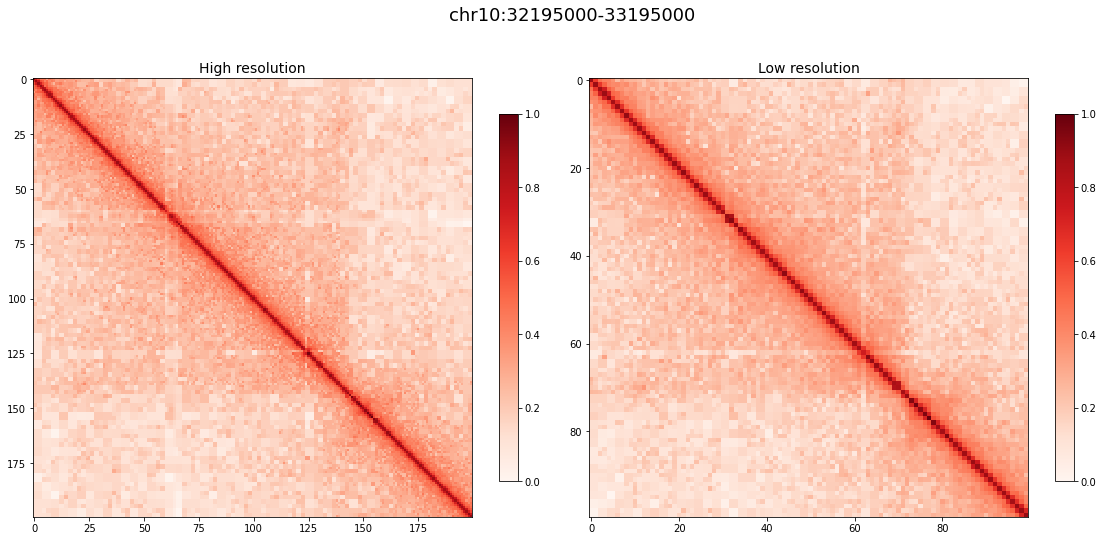

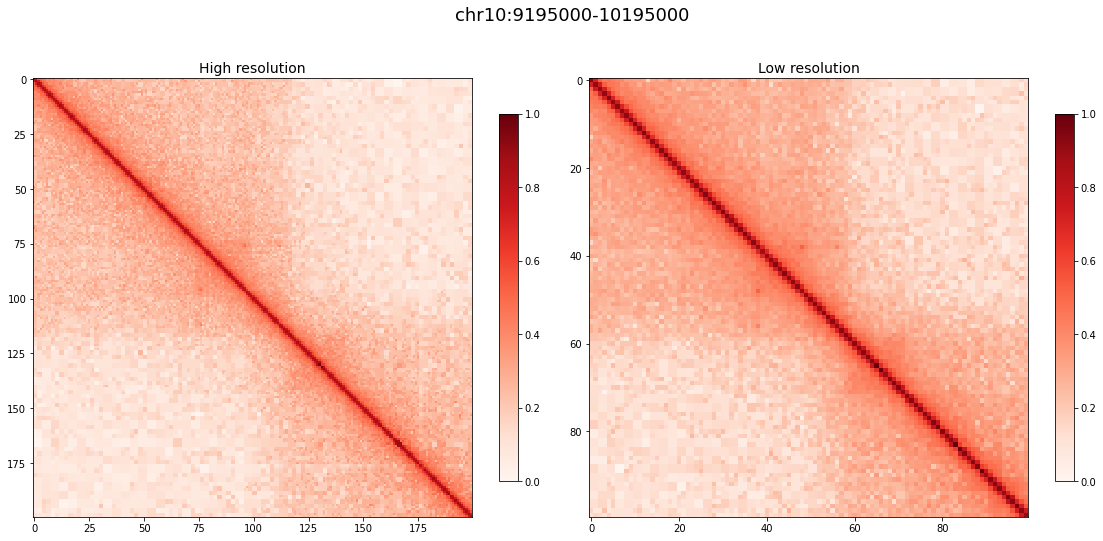

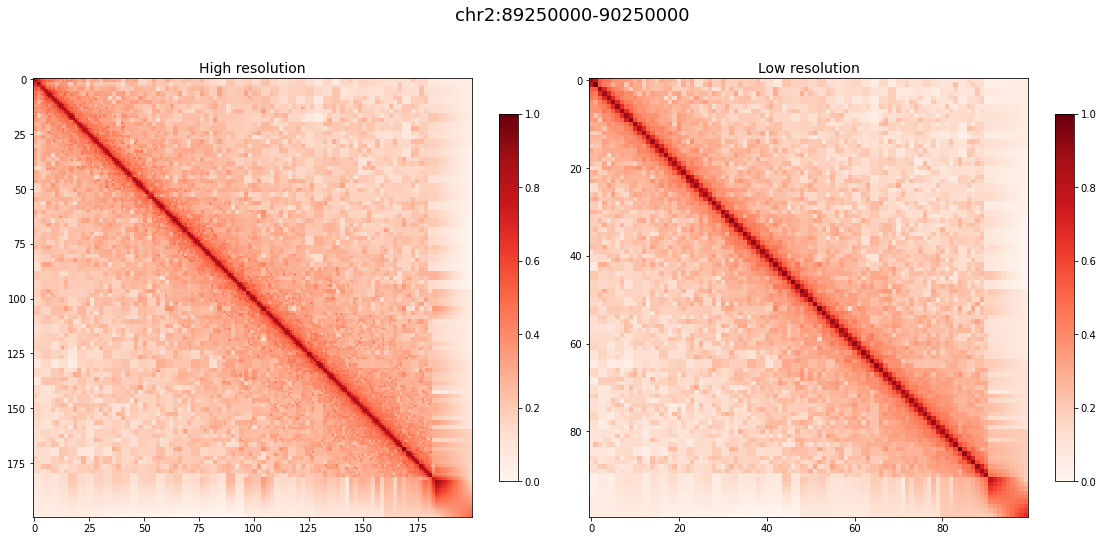

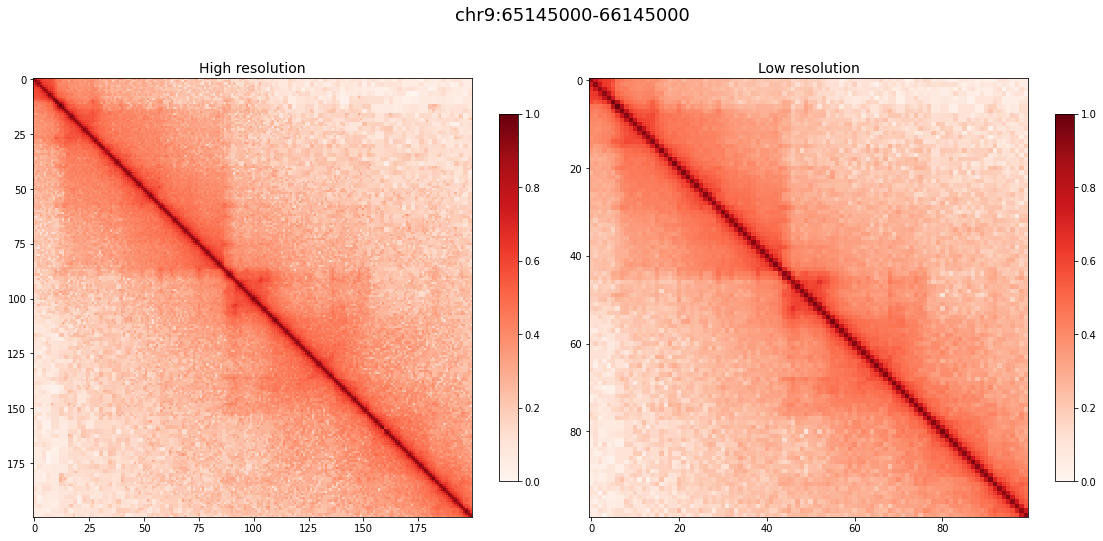

In [14]:
N = 10
ids = np.random.randint(0, len(seq_list), N)
for i in ids:
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    fig.suptitle('%s:%d-%d' % coord_list[i], fontsize=18)
    M1 = ax[0].imshow(high_stack[i], cmap='Reds', interpolation='none', 
                      vmin=0, vmax=1.0)
    M2 = ax[1].imshow(low_stack[i], cmap='Reds', interpolation='none', 
                      vmin=0, vmax=1.0)
    ax[0].set_title('High resolution', fontsize=14)
    ax[1].set_title('Low resolution', fontsize=14)
    plt.colorbar(M1, ax=ax[0], shrink=0.7)
    plt.colorbar(M2, ax=ax[1], shrink=0.7)
    plt.tight_layout()
    plt.show()
    